In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from sklearn.impute import SimpleImputer


In [36]:
# Load datasets
customers_df = pd.read_csv('/kaggle/input/customers/Customers.csv')
transactions_df = pd.read_csv('/kaggle/input/transactions/Transactions.csv')
products_df = pd.read_csv('/kaggle/input/products/Products.csv')

In [37]:
# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

# Merge datasets: Customer + Transaction + Product information
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="left")
merged_df = pd.merge(merged_df, products_df, on="ProductID", how="left")

# Handle missing values in merged_df
merged_df = merged_df.dropna()

In [38]:
# Aggregate transaction data per customer
agg_transaction = merged_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    unique_categories=('Category', lambda x: len(set(x))),
    num_transactions=('TransactionID', 'count')
).reset_index()

# Merge aggregated transaction data with customer profile information
customer_features = pd.merge(customers_df[['CustomerID', 'Region']], agg_transaction, on='CustomerID', how='left')

# One-hot encode 'Region' for clustering
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)


In [39]:
# Feature selection for clustering: Numerical features
features = customer_features[['total_spend', 'total_quantity', 'unique_categories', 'num_transactions'] + 
                             [col for col in customer_features.columns if col.startswith('Region_')]]

# Standardizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Handle missing values (if any) in scaled_features
imputer = SimpleImputer(strategy='mean')
scaled_features = imputer.fit_transform(scaled_features)


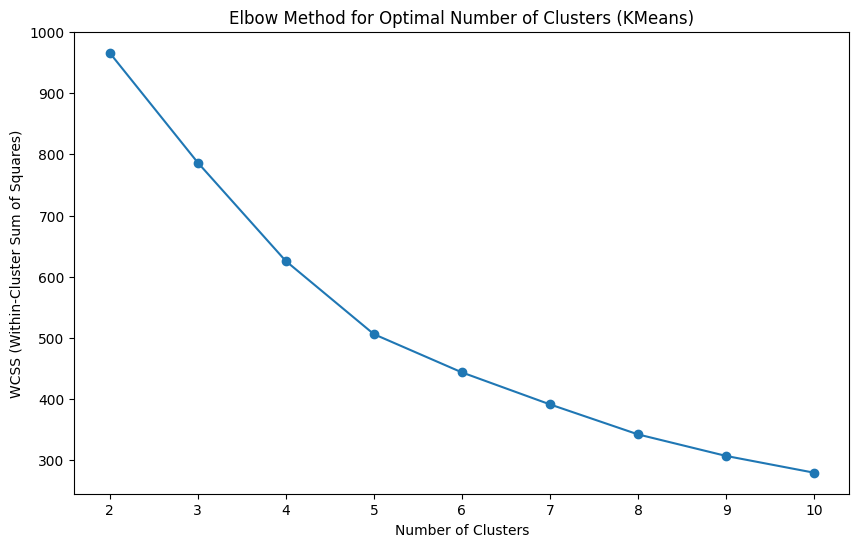

In [40]:
# Elbow method to determine optimal number of clusters for KMeans
wcss = []
for i in range(2, 11):  # Trying from 2 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method for KMeans
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


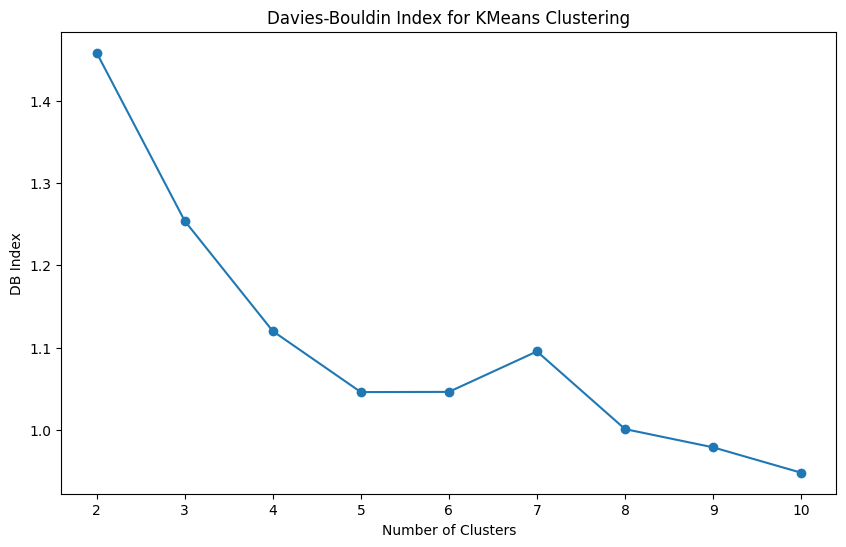

In [41]:
# Davies-Bouldin Index for KMeans with different numbers of clusters
dbi_kmeans = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    dbi_kmeans.append(davies_bouldin_score(scaled_features, kmeans.labels_))

# Plot Davies-Bouldin Index for KMeans
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), dbi_kmeans, marker='o')
plt.title('Davies-Bouldin Index for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()


In [42]:
# Apply Gaussian Mixture Model (GMM) for 2 to 10 clusters and calculate Davies-Bouldin Index
dbi_gmm = []
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(scaled_features)
    gmm_labels = gmm.predict(scaled_features)
    dbi_gmm.append(davies_bouldin_score(scaled_features, gmm_labels))


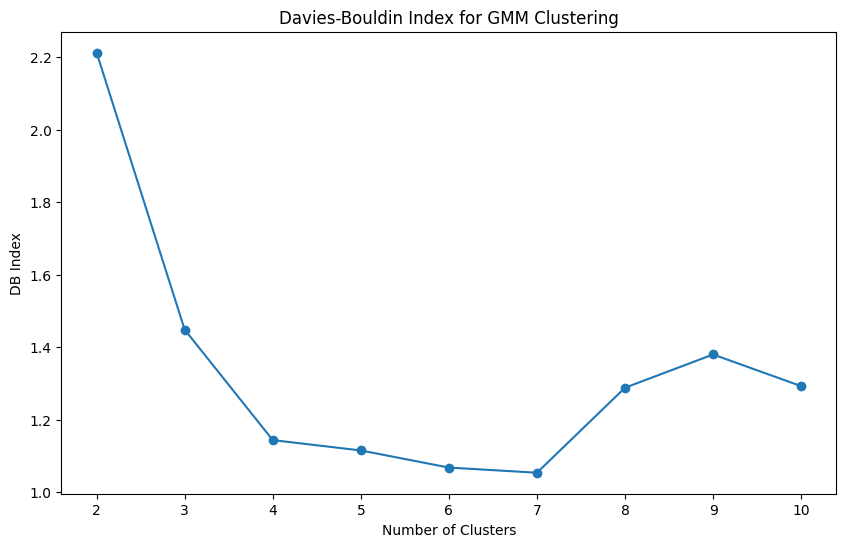

In [43]:
# Plot Davies-Bouldin Index for GMM
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), dbi_gmm, marker='o')
plt.title('Davies-Bouldin Index for GMM Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()


In [44]:
# Select optimal number of clusters based on the lowest DBI from KMeans and GMM
optimal_kmeans_clusters = np.argmin(dbi_kmeans) + 2  # +2 because range starts at 2
optimal_gmm_clusters = np.argmin(dbi_gmm) + 2  # +2 because range starts at 2

print(f"Optimal number of clusters for KMeans (based on DBI): {optimal_kmeans_clusters}")
print(f"Optimal number of clusters for GMM (based on DBI): {optimal_gmm_clusters}")


Optimal number of clusters for KMeans (based on DBI): 10
Optimal number of clusters for GMM (based on DBI): 7


In [45]:
# Applying the final KMeans model with optimal clusters
kmeans = KMeans(n_clusters=optimal_kmeans_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_features['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)


In [46]:
# Apply GMM with optimal clusters
gmm = GaussianMixture(n_components=optimal_gmm_clusters, random_state=42)
customer_features['Cluster_GMM'] = gmm.fit_predict(scaled_features)

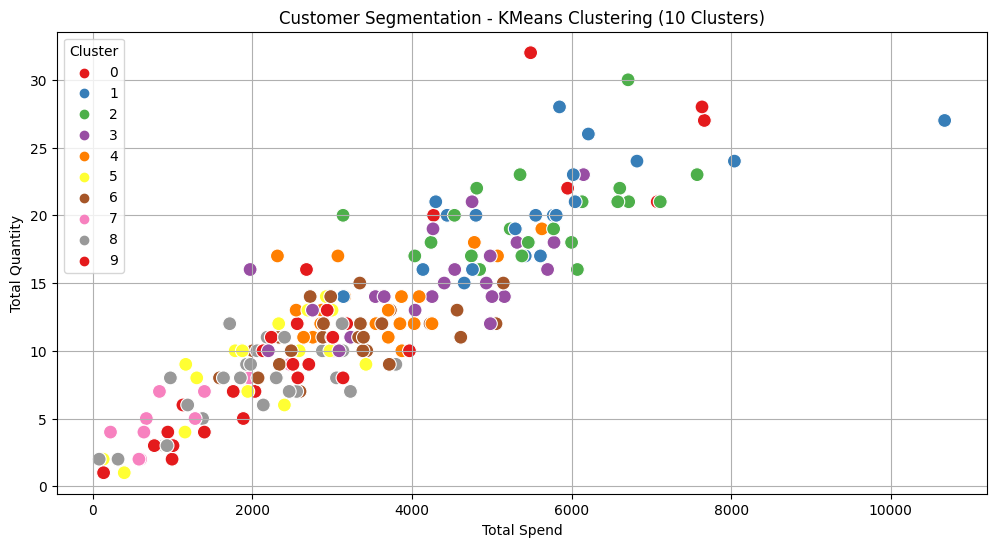

In [47]:
# Visualize the clusters from KMeans
plt.figure(figsize=(12, 6))
sns.scatterplot(x='total_spend', y='total_quantity', hue='Cluster_KMeans', data=customer_features, palette='Set1', s=100)
plt.title(f'Customer Segmentation - KMeans Clustering ({optimal_kmeans_clusters} Clusters)')
plt.xlabel('Total Spend')
plt.ylabel('Total Quantity')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


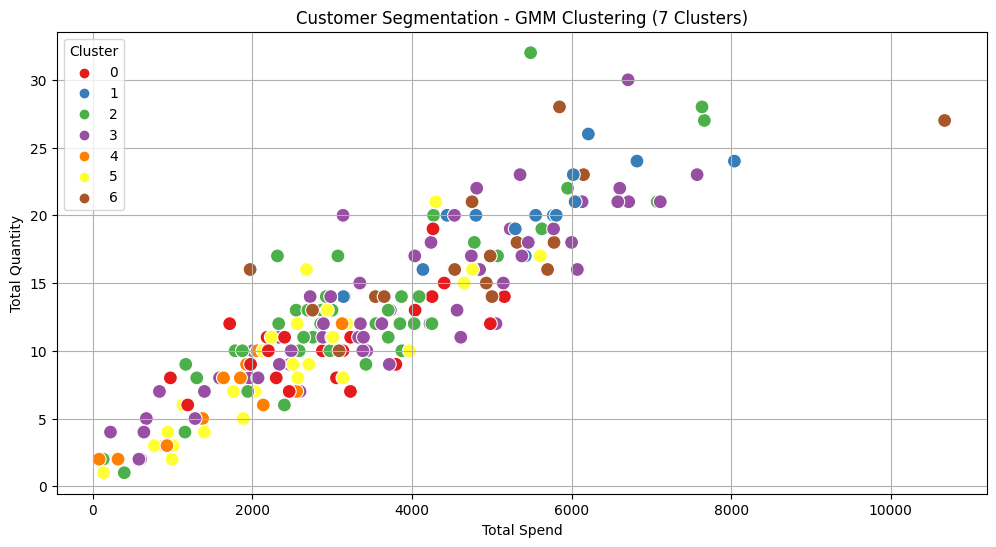

In [48]:
# Visualize the clusters from GMM
plt.figure(figsize=(12, 6))
sns.scatterplot(x='total_spend', y='total_quantity', hue='Cluster_GMM', data=customer_features, palette='Set1', s=100)
plt.title(f'Customer Segmentation - GMM Clustering ({optimal_gmm_clusters} Clusters)')
plt.xlabel('Total Spend')
plt.ylabel('Total Quantity')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

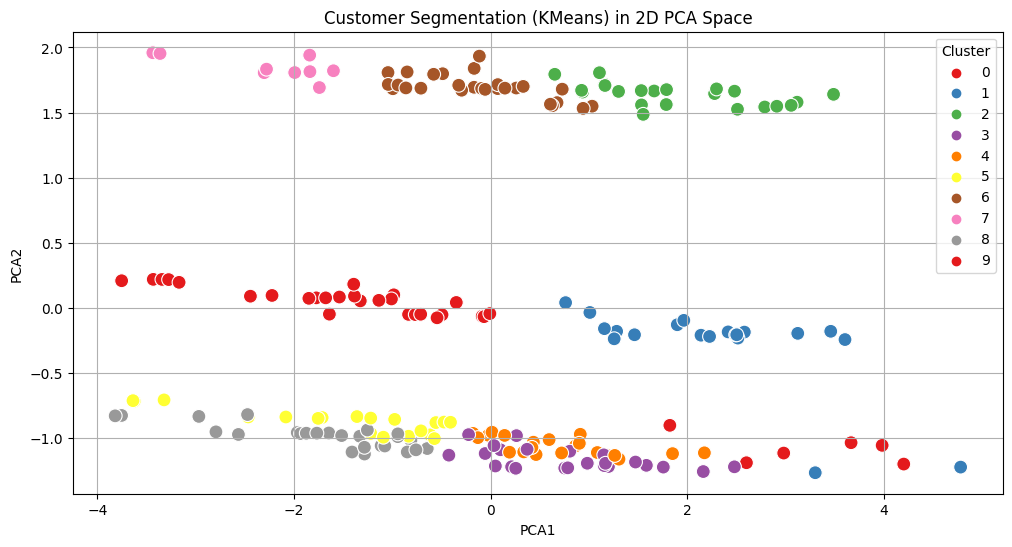

In [49]:
# Apply PCA to reduce dimensions for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the customer features dataframe
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

# Plot the clusters in 2D using PCA components
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', data=customer_features, palette='Set1', s=100)
plt.title(f'Customer Segmentation (KMeans) in 2D PCA Space')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [50]:
# Apply KMeans clustering with the optimal number of clusters (based on previous calculation)
optimal_kmeans_clusters = 10 
kmeans = KMeans(n_clusters=optimal_kmeans_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_features['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

In [51]:
# Apply GMM clustering with the optimal number of clusters (based on previous calculation)
optimal_gmm_clusters = 7 
gmm = GaussianMixture(n_components=optimal_gmm_clusters, random_state=42)
customer_features['Cluster_GMM'] = gmm.fit_predict(scaled_features)


In [52]:
# Calculate Davies-Bouldin Index (DBI) for KMeans
dbi_kmeans = davies_bouldin_score(scaled_features, customer_features['Cluster_KMeans'])
print(f'Davies-Bouldin Index for KMeans: {dbi_kmeans}')


Davies-Bouldin Index for KMeans: 0.9481092321248349


In [53]:
# Calculate Davies-Bouldin Index (DBI) for GMM
dbi_gmm = davies_bouldin_score(scaled_features, customer_features['Cluster_GMM'])
print(f'Davies-Bouldin Index for GMM: {dbi_gmm}')

Davies-Bouldin Index for GMM: 1.0536723816726117


In [54]:

customer_features.to_csv('customer_clusters.csv', index=False)